In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

from itertools import product

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report


# Repeat the prior data mining example to identify the top 10 long/short trades
# using the last 10 years. But apply ML to determine whether we should actually
# take up those trades proposed by the seasonal strategy. In this case,
# conditional on a signal, assign a 1 or 0 if the strategy would have yielded
# a return of at least 1% (to roughly account for slippage or bid/ask spread)
# and use a random forest to predict, based off of a number of indicators:
# 1) Other seasonal indicators: Winrate for last year, last 3 yrs, last 5 yrs
# 2) Estimate of daily volatility (EWM with span parameter = 30)
# 3) Simple momentum indicator for the stock and the SP500 overall: 'up'
#    if EWM with span of 5 (1 week) exceeds the EWM with span of 10 (2 weeks)
# 4) Returns relative to yesterday's price, for stock and SP500 overall

def seasonal_return(data, symbol, start_date, end_date, first_year, last_year):
    data_list = []
    # Deal with Feb 29: assign start/end dates to Mar 1
    if start_date == '02-29': start_date = '03-01'
    if end_date == '02-29': end_date = '03-01'
    for year in range(first_year, (last_year + 1)):
        full_start_date = str(year) + '-' + start_date
        full_end_date = str(year) + '-' + end_date
        trade_start_date = data.loc[full_start_date, 'Price Date']
        trade_end_date = data.loc[full_end_date, 'Price Date']
        start_price = data.loc[full_start_date, symbol]

        # If price data is missing, skip that year
        if np.isnan(start_price):
            continue
        end_price = data.loc[full_end_date, symbol]
        if np.isnan(end_price):
            continue
        returns = np.log(end_price / start_price)
        data_list.append([symbol, year, trade_start_date, start_price,
                          trade_end_date,
                          end_price, returns])

    df = pd.DataFrame(data_list, columns=['Symbol', 'Year', 'Init Date',
        'Init Price', 'Final Date', 'Final Price', 'Return'])
    return df


def return_stats(x, risk_free_rate=0):
    d = {}
    d['N'] = x['Symbol'].count()
    d['avg r'] = x['Return'].mean()
    d['vol'] = x['Return'].std()
    downsides = x[x['Return'] < risk_free_rate]['Return']
    d['downside dev'] = 0 if downsides.count() == 0 else downsides.std()
    upsides = x[-x['Return'] < risk_free_rate]['Return']
    d['upside dev'] = 0 if upsides.count() == 0 else upsides.std()
    d['up'] = sum(x['Return'] > risk_free_rate)
    return pd.Series(d, index=['N', 'avg r', 'vol', 'downside dev',
        'upside dev', 'up'])


# Historical rate of stock going up (i.e. winrate if we are long)
def historical_up_rate(data, symbol, start_date, end_date, first_year, last_year):
    up_list = []
    # Deal with Feb 29: assign start/end dates to Mar 1
    if start_date == '02-29': start_date = '03-01'
    if end_date == '02-29': end_date = '03-01'
    for year in range(first_year, (last_year + 1)):
        full_start_date = str(year) + '-' + start_date
        full_end_date = str(year) + '-' + end_date
        trade_start_date = data.loc[full_start_date, 'Price Date']
        trade_end_date = data.loc[full_end_date, 'Price Date']
        start_price = data.loc[full_start_date, symbol]

        # If price data is missing, skip that year
        if np.isnan(start_price):
            continue
        end_price = data.loc[full_end_date, symbol]
        if np.isnan(end_price):
            continue

        if end_price >= start_price:
            ret = 1
        else:
            ret = 0
        up_list.append(ret)
    return np.mean(up_list)

In [2]:
# Pull the adjusted close prices off Yahoo Finance
df = pd.read_csv("S&P500-Symbols.csv")
tickers = list(df['Symbol'])
start_date = '1989-01-01'
end_date = '2024-01-03'  # Get data a few days past end of year to backfill

# Either pull from Yahoo finance, or for read the pre-downloaded CSV
# data = pd.DataFrame(yf.download(tickers, start_date, end_date)['Adj Close'])
# data.reset_index().to_csv("S&P500-adjusted-close.csv", index=False)
data = pd.read_csv('S&P500-adjusted-close.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
all_dates = pd.date_range(start_date, end_date)
data['Price Date'] = data.index

# Backfill with trading prices for missing dates
data = data.reindex(all_dates, method='bfill')
sp500_dates_added = pd.read_csv("S&P500-Info.csv")[['Symbol', 'Date added']]
all_stocks = data.columns.drop(labels='Price Date')
data = data[data.index < '2024-01-01']

# Restrict to stocks that have data back in 2009, total of 432
sub_cols = data.columns[data.loc['2009-01-01'].notna()]
sub_cols = sub_cols.append(pd.Index(['Price Date']))
sub_stocks = data[sub_cols].columns.drop(labels='Price Date')
sub_data = data[sub_cols][data.index >= '2009-01-01']

# Specifications for the technical strategy
hold_range = [7, 14, 28]  # hold for 1, 2, or 4 weeks
delay_range = [0, 5, 10]  # search for trades 0, 5, 10 days after trade window

# Trade windows start on the 1st/15th of each month
start_months = list(range(1, 12 + 1))
start_days = ['-01', '-15']
initial_dates = [str(i) + j for i, j in product(start_months, start_days)]

Do not run the below cell, since it takes ~60 minutes to calculate the seasonal data. The results are already saved in a CSV which is imported in the following cell

In [ ]:
# Running the below loop for 2019, 2020, 2021 start/middle of months takes about an hour
# The results are saved in the CSV, so just load that instead

all_returns_list = []

for trade_year in [2019, 2020, 2021]:
    start_year = trade_year - 10
    end_year = trade_year - 1

    for initial_date in initial_dates:
        initial_calendar_year = datetime.strptime(
            str(trade_year) + "-" + initial_date, "%Y-%m-%d")

        # Delay refers to how many days after the 1st or 15th we start the trade
        for delay in delay_range:
            start_calendar_year = initial_calendar_year + timedelta(days=delay)
            start_calendar = start_calendar_year.strftime('%m-%d')

            for hold_length in hold_range:
                end_calendar = (start_calendar_year + timedelta(days=hold_length)
                                ).strftime('%m-%d')
                stock_returns_list = []

                for stock in sub_stocks:
                    stock_returns_list.append(seasonal_return(
                        sub_data, stock,start_calendar, end_calendar,
                        start_year, end_year))

                seasonal_returns = pd.concat(stock_returns_list)
                symbol_stats = seasonal_returns.groupby('Symbol').apply(
                    return_stats, risk_free_rate=0)
                symbol_stats['trade window'] = initial_calendar_year.strftime(
                    '%Y-%m-%d')
                symbol_stats['start date'] = start_calendar_year
                symbol_stats['end date'] = end_calendar
                symbol_stats['Sharpe Long'] = (symbol_stats['avg r']/
                    symbol_stats['vol'])
                symbol_stats['Sharpe Short'] = -(symbol_stats['avg r']/
                    symbol_stats['vol'])
                symbol_stats['hold length'] = hold_length
                all_returns_list.append(symbol_stats)

all_returns = pd.concat(all_returns_list)
# all_returns.to_csv('seasonal_trades_2019_2021.csv')

In [3]:
# Import the CSV of all returns
all_returns = pd.read_csv('seasonal_trades_2019_2021.csv')

# Annualize returns, extract
all_returns['annualized r'] = (all_returns['avg r'] * 365 /
                               all_returns['hold length'])
all_returns['trade year'] = all_returns['trade window'].str.slice(0, 4)

# Part 2: Generate features at the time of trade

We select the candidate seasonal trades, which have an annualized return > 50%, 6/10+ winrate in the last 10 years, and total return of at least 2%. Sort by highest Sharpe ratio using historical seasonal trades, and select the top 10 for each trade window.

Recall the features are
1) past 3 years', past 5 years' winrate (up/down return ratio)
2) exponentially weighted daily volatility for both the stock and the S&P500 (high volatility may make technical trades unattractive, since it could suggest the presence of other factors moving prices. And volatility spikes may indicate large stock movements downward)
3) the ratio of the exponentially weighted moving average centered around the last week (5 days) vs last two weeks (10 days) for the stock and S&P500, a form of near-term momentum
4) yesterday's returns for the stock and S&P500

Also compute the realized returns for each seasonal trade.

In [5]:
# Select the top 10 trades per trade window, meeting the criteria
long_positions = all_returns[(all_returns['annualized r'] > 0.4) & 
(all_returns.up >= 6) & (all_returns['avg r'] > .02)].sort_values(
    'Sharpe Long', ascending=False).groupby('trade window').head(10)

# Define the feature functions

# Historical winrates
long_positions['past3yr'] = long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'], row['start date'][5:10], row['end date'],
    int(row['trade year']) - 3, int(row['trade year']) - 1), axis=1)

long_positions['past5yr'] = long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'], row['start date'][5:10], row['end date'],
    int(row['trade year']) - 5, int(row['trade year']) - 1), axis=1)

# Daily volatility with exponentially weighted moving average
# We get in a bit of trouble with the backfilled data: it would result in
# repetitions of the same price over non-trading days, reducing volatility,
# so move forward to the day we would trade and use non-backfilled data

data_no_backfill = data[data.index == data['Price Date']]

# Note that these functions are shifted by 1 day backwards, to avoid knowing the
# current day's closing price when making a trade decision during the day

def get_ewm_vol(data, symbol, date, span=10):
    stock_rets = np.log(data[symbol] / data[symbol].shift(1)).shift(1)
    return stock_rets.ewm(span).std().loc[date]

long_positions['ewm_vol'] = long_positions.apply(lambda row: get_ewm_vol(
    data_no_backfill, row['Symbol'], data.loc[row['start date']]['Price Date'],
    30), axis=1)

# EWMA of price: compare between a long/short window to determine
# whether the signal is long
def get_ewm_momentum(data, symbol, date, long_window, short_window):
    short_ewma = data[symbol].ewm(short_window).mean().shift(1).loc[date]
    long_ewma = data[symbol].ewm(long_window).mean().shift(1).loc[date]
    return np.log(short_ewma / long_ewma)

long_positions['long_momentum'] = long_positions.apply(
    lambda row: get_ewm_momentum(data_no_backfill, row['Symbol'],
        data.loc[row['start date']]['Price Date'],
        long_window=10, short_window=5), axis=1)

# Generates an X-day back return. With days_back = 1, it is yesterday's observed
# return

def get_recent_return(data, symbol, date, days_back=1):
    return np.log(data[symbol]/data[symbol].shift(days_back)).shift(1).loc[date]

long_positions['yesterday_ret'] = long_positions.apply(
    lambda row: get_recent_return(data_no_backfill, row['Symbol'],
                                  data.loc[row['start date']]['Price Date'],
                                  days_back=1), axis=1)

# Get SP500 EWM vol/average ratio and yesterday returns, making sure not to backfill
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])
all_dates = pd.date_range(start_date, end_date)

long_positions['sp500_ewm_vol'] = long_positions.apply(
    lambda row: get_ewm_vol(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'],10), axis=1)

long_positions['sp500_ewma'] = long_positions.apply(
    lambda row: get_ewm_momentum(spx, 'Adj Close',
     data.loc[row['start date']]['Price Date'], 
     long_window=10, short_window=5), axis=1)

long_positions['sp500_yest_ret'] = long_positions.apply(
    lambda row: get_recent_return(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'],
        days_back=1), axis=1)

[*********************100%%**********************]  1 of 1 completed


# Part 3: Random Forest on Seasonal Trades

Classify the actual returns into 1 or 0: a 1 if the actual return exceeds 2%, 0 otherwise. The choice of 2% is so that it is clear it is a winning trade. Given that many stocks have daily volatilities of around 1%, a smaller actual return (e.g. just 1%) would be us overlaying an ML model on what is largely noise. After defining our classifier, fit a random forest model on our training data set.

In [6]:
# Get the actual returns for the start/end date

def get_actual_return(data, symbol, start_date, end_date):
    return np.log(data[symbol].loc[end_date]/data[symbol].loc[start_date])

long_positions['actual_return'] = long_positions.apply(lambda row:
    get_actual_return(data, row['Symbol'], row['start date'],
        row['trade year']+'-'+row['end date']), axis = 1)

# 280/720 long trades would have absolute returns over 2%,
# i.e. ~39% of the trades
long_positions['outcome'] = np.where(
    long_positions['actual_return'] > 0.02, 1, 0)

# Implement Random Forest
X = long_positions[['past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y = long_positions['outcome'].values

Generate a ROC curve as well as some classification reports. For the ROC curve, the general goal is to maximize the area under the curve, and to have the curve above the line y=x (which would be the outcome of a coin flip).

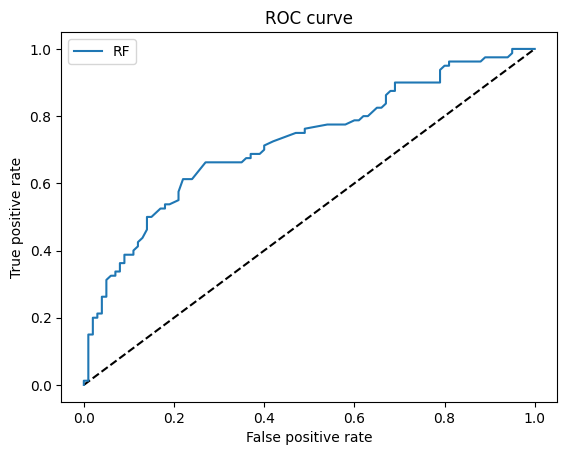

              precision    recall  f1-score   support

    no_trade       0.68      0.82      0.75       100
       trade       0.70      0.53      0.60        80

    accuracy                           0.69       180
   macro avg       0.69      0.67      0.67       180
weighted avg       0.69      0.69      0.68       180

Average winrate in all seasonal trades  0.44
Average return in all seasonal trades: 0.010
Average return in random forest trades: 0.039


In [152]:
# Split data into training/testing sets
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, range(len(y)), train_size=0.75, random_state = np.random.seed(1234))

model = RandomForestClassifier(random_state = np.random.seed(1234))

model.fit(X_train,y_train)

y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(classification_report(y_test, y_pred,
                            target_names=['no_trade', 'trade']))
print('Average winrate in all seasonal trades %5.2f' %
     long_positions.iloc[indices_test]['outcome'].mean())
print('Average return in all seasonal trades: %5.3f' %
      long_positions.iloc[indices_test]['actual_return'].mean())
print('Average return in random forest trades: %5.3f' %
      long_positions.iloc[indices_test][y_pred==1]['actual_return'].mean())

## Discussion
The random forest improves precision for trades (the ratio of true positives divided by classified positives) from 0.44 when we would have taken every seasonal trade recommendation, to 0.70 when we use the classifier.

Precision is the metric we care the most about, since we "lose nothing" by not participating in a trade, and can always scale up the sizes of our trades to account for the fewer total number of trades we make. If we found ourselves with not enough trades, we could increase the "recall" of the initial seasonal strategy by considering more than just the top 10 trades by Sharpe ratio, and then applying the random forest. With the random forest, the average returns per trade are much higher, increasing from 1.0% if we traded every seasonal strategy, to 3.9% if we used the classifier.

## Purging serial correlation in the training and testing data
However, there's a potential issue with the above methodology and report: the current way of splitting the data into training and testing sets could have data from the same trade window in both the training and testing sets. If two trades were to start at the same time, for example, the S&P500 features would exactly align, and if we think there is serial correlation in stock prices (e.g. general market movements), there will be leakage. We can try to "purge" much of this serial correlation by making sure the test and training datasets never include the same trade windows.

To do this, I manually split the data as such. Here, I set the test sets to be Jan 1 to Apr 15 in 2019, May 1 to Aug 15 in 2020, and Sep 1 to Dec 15 in 2021 for trading windows, and the training sets to be everything else (I don't establish a gap or "embargo" between the trade dates, although some of the EWMA indicators might have some leakage across adjacent periods).

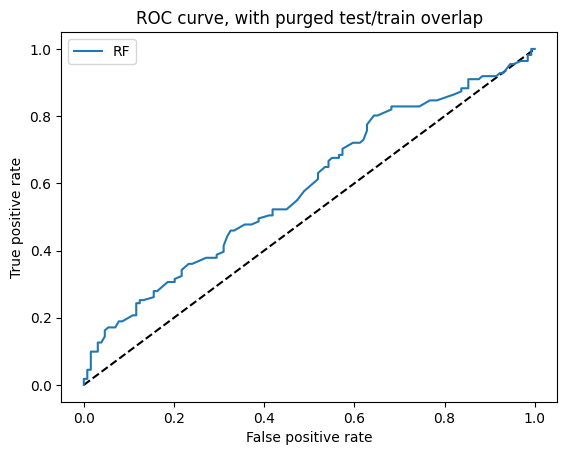

              precision    recall  f1-score   support

    no_trade       0.57      0.87      0.69       129
       trade       0.62      0.25      0.36       111

    accuracy                           0.58       240
   macro avg       0.60      0.56      0.53       240
weighted avg       0.60      0.58      0.54       240

Average winrate in all seasonal trades  0.46
Average return in all seasonal trades: 0.019
Average return in random forest trades: 0.031


In [154]:
long_positions['trade window date'] = pd.to_datetime(long_positions['trade window'])

# Define the test data's endpoints
a1 = pd.to_datetime('2019-01-01')
a2 = pd.to_datetime('2019-04-15')
b1 = pd.to_datetime('2020-05-01')
b2 = pd.to_datetime('2020-08-15')
c1 = pd.to_datetime('2021-09-01')
c2 = pd.to_datetime('2021-12-15')

test_flag = (
    ((long_positions['trade window date'] >= a1) & (long_positions['trade window date'] <= a2)) |
    ((long_positions['trade window date'] >= b1) & (long_positions['trade window date'] <= b2)) |
    ((long_positions['trade window date'] >= c1) & (long_positions['trade window date'] <= c2)))

train_flag = ~test_flag
train_set = long_positions[train_flag]
test_set = long_positions[test_flag]

X_train = train_set[['past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y_train = train_set['outcome'].values

X_test = test_set[['past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y_test = test_set['outcome'].values

model = RandomForestClassifier(random_state = np.random.seed(1234))

model.fit(X_train,y_train)

y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve, with purged test/train overlap')
plt.legend(loc='best')
plt.show()

print(classification_report(y_test, y_pred,
                            target_names=['no_trade', 'trade']))
print('Average winrate in all seasonal trades %5.2f' %
     test_set['outcome'].mean())
print('Average return in all seasonal trades: %5.3f' %
      test_set['actual_return'].mean())
print('Average return in random forest trades: %5.3f' %
      test_set[y_pred==1]['actual_return'].mean())

## Discussion

This is somewhat apples and oranges compared to the previous set of performance metrics, since the test set is different. However, some general trends can be picked up: the ROC curve is now closer to the y=x line and has a lower area underneath (also reflected in the lower f1 scores compared to the first test-train split). The true positive rate for trades is still higher than if we did not use the classifier (62% vs. 46%) and there is still an improvement in the average return of all trades, although the effect is more modest than in the first test/training data split, only from 1.9% to 3.1%.

However, a better test of this model involves looking at how it would perform in a backtest in 2022 and 2023, reflecting a bearish and bullish market, respectively.

# Part 4: Applying the model out of sample

Let's see what happens when we apply this model to 2022 and 2023. The below code generates the relevant datasets up to 2023, and is mostly a repeat of the earlier code for 2019-2021.

## Downloading the data, generating the features

In [90]:
# DO NOT RUN the below, and instead import the CSV file in the next cell
later_returns_list = []

for trade_year in [2022, 2023]:
    start_year = trade_year - 10
    end_year = trade_year - 1

    for initial_date in initial_dates:
        initial_calendar_year = datetime.strptime(
            str(trade_year) + "-" + initial_date, "%Y-%m-%d")

        # Delay refers to how many days after the 1st or 15th we start the trade
        for delay in delay_range:
            start_calendar_year = initial_calendar_year + timedelta(days=delay)
            start_calendar = start_calendar_year.strftime('%m-%d')

            for hold_length in hold_range:
                end_calendar = (start_calendar_year + timedelta(days=hold_length)
                                ).strftime('%m-%d')
                stock_returns_list = []

                for stock in sub_stocks:
                    stock_returns_list.append(seasonal_return(
                        sub_data, stock,start_calendar, end_calendar,
                        start_year, end_year))

                seasonal_returns = pd.concat(stock_returns_list)
                symbol_stats = seasonal_returns.groupby('Symbol').apply(
                    return_stats, risk_free_rate=0)
                symbol_stats['trade window'] = initial_calendar_year.strftime(
                    '%Y-%m-%d')
                symbol_stats['start date'] = start_calendar_year
                symbol_stats['end date'] = end_calendar
                symbol_stats['Sharpe Long'] = (symbol_stats['avg r']/
                    symbol_stats['vol'])
                symbol_stats['Sharpe Short'] = -(symbol_stats['avg r']/
                    symbol_stats['vol'])
                symbol_stats['hold length'] = hold_length
                later_returns_list.append(symbol_stats)


later_returns = pd.concat(later_returns_list)

# Annualize returns
later_returns['annualized r'] = (later_returns['avg r'] * 365 /
                                 later_returns['hold length'])
later_returns['trade year']=later_returns['trade window'].str.slice(0,4)

# later_returns.to_csv('seasonal_trades_2022_2023.csv')

In [9]:
# Read in seasonal long trades identified for 2022/2023 from CSV
later_returns = pd.read_csv('seasonal_trades_2022_2023.csv')

later_long_positions = later_returns[(later_returns['annualized r'] > 0.4) &
                                     (later_returns.up >= 6) &
                                     later_returns['avg r'] > .02].sort_values(
    'Sharpe Long', ascending=False).groupby('trade window').head(10)

# Calculate the feature values
later_long_positions['past3yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-3,int(row['trade year'])-1), axis = 1)

later_long_positions['past5yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-5,int(row['trade year'])-1), axis = 1)

later_long_positions['ewm_vol'] = later_long_positions.apply(
    lambda row: get_ewm_vol(data, row['Symbol'], row['start date'], 30), axis=1)

later_long_positions['long_momentum'] = later_long_positions.apply(
    lambda row: get_ewm_momentum(data, row['Symbol'], row['start date'],
        long_window=10, short_window=5), axis=1)

later_long_positions['yesterday_ret'] = later_long_positions.apply(
    lambda row: get_recent_return(data_no_backfill, row['Symbol'],
                                  data.loc[row['start date']]['Price Date'],
                                  days_back=1), axis=1)

later_long_positions['sp500_ewm_vol'] = later_long_positions.apply(
    lambda row: get_ewm_vol(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'], 10), axis=1)

later_long_positions['sp500_ewma'] = later_long_positions.apply(
    lambda row: get_ewm_momentum(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'], long_window=10,
        short_window=5), axis=1)

later_long_positions['sp500_yest_ret'] = later_long_positions.apply(
    lambda row: get_recent_return(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'], days_back=1), axis=1)

later_long_positions['actual_return'] = later_long_positions.apply(
    lambda row: get_actual_return(data, row['Symbol'], row['start date'],
        str(row['trade year']) + '-' + row['end date']), axis=1)

later_long_positions['outcome'] = np.where(
    later_long_positions['actual_return'] > 0.02, 1, 0)

## Fit the model on data from 2019-2021, to predict trades for 2022

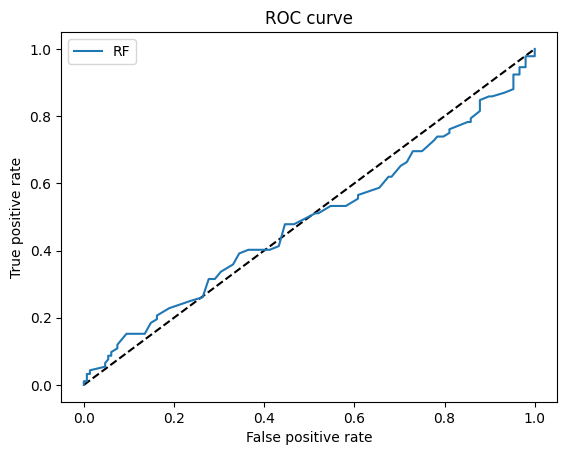

              precision    recall  f1-score   support

    no_trade       0.61      0.57      0.59       148
       trade       0.37      0.41      0.39        92

    accuracy                           0.51       240
   macro avg       0.49      0.49      0.49       240
weighted avg       0.52      0.51      0.51       240

Average winrate in all seasonal trades  0.38
Average return in all seasonal trades: 0.002
Std Dev of returns in all seasonal trades: 0.071
Average return in random forest trades: 0.001
Std Dev of returns in random forest trades: 0.077


In [155]:
model = RandomForestClassifier(random_state = np.random.seed(1234))
model.fit(X, y) # Note that X and y were from the initial dataset, from 2019-2021

long_2022 = later_long_positions[later_long_positions['trade year'] == 2022]
X_2022 = long_2022[['past3yr', 'past5yr','ewm_vol', 'long_momentum',
                    'yesterday_ret','sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y_2022 = long_2022['outcome'].values

rf_trade_2022_prob = model.predict_proba(X_2022)[:, 1]
rf_trade_2022 = model.predict(X_2022)
fpr_rf, tpr_rf, _ = roc_curve(y_2022, rf_trade_2022_prob)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


print(classification_report(y_2022, rf_trade_2022,
                            target_names=['no_trade', 'trade']))

print('Average winrate in all seasonal trades %5.2f' %
      long_2022['outcome'].mean())
print('Average return in all seasonal trades: %5.3f' %
      long_2022['actual_return'].mean())
print('Std Dev of returns in all seasonal trades: %5.3f' %
      long_2022['actual_return'].std())
print('Average return in random forest trades: %5.3f' %
      long_2022[rf_trade_2022==1]['actual_return'].mean())
print('Std Dev of returns in random forest trades: %5.3f' %
      long_2022[rf_trade_2022==1]['actual_return'].std())

## Discussion

This model results in a **decrease** in overall precision of trades relative to taking all trades, and a slight **decrease** in average returns (still significantly smaller than the volatility in returns, 7+%). Both of these effects are very minor and likely within the expected effects from noise.

Overall, this is not a good performance for the long seasonal trading strategy, or the random forest. However, if we consider that the S&P500 dropped around 20% in 2022, perhaps a 0% return isn't so bad.

But let's consider this model's performance in 2023, a bull year. To construct the training data, add the data from 2019-2021 to that from 2022 to generate the set of training data ("to 2023") which will be used to classify potential 2023 seasonal trades.

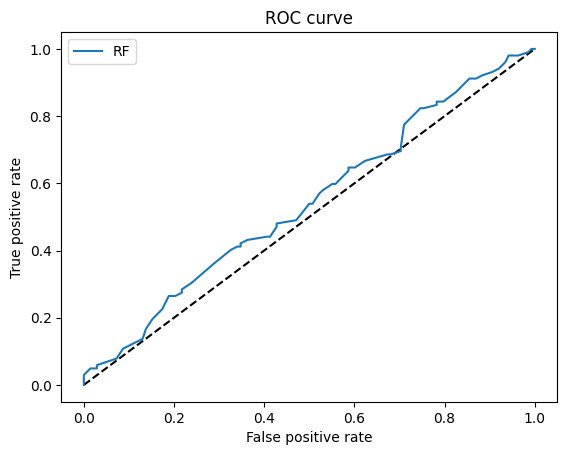

              precision    recall  f1-score   support

    no_trade       0.58      0.86      0.70       138
       trade       0.47      0.17      0.25       102

    accuracy                           0.57       240
   macro avg       0.53      0.51      0.47       240
weighted avg       0.54      0.57      0.50       240

Average winrate in all seasonal trades  0.42
Average return in all seasonal trades: 0.015
Std Dev of returns in all seasonal trades: 0.055
Average return in random forest trades: 0.026
Std Dev of returns in random forest trades: 0.047


In [156]:
# Repeat for 2023, using data from 2019-2022 as training data
long_positions_to_2023 = pd.concat([long_positions,
    later_long_positions[later_long_positions['trade year'] == 2022]])

X_to_2023 = long_positions_to_2023[['past3yr', 'past5yr', 'ewm_vol',
'long_momentum', 'yesterday_ret','sp500_ewm_vol', 'sp500_ewma',
'sp500_yest_ret']].values
y_to_2023 = long_positions_to_2023['outcome'].values

model = RandomForestClassifier(random_state = np.random.seed(1234))
model.fit(X_to_2023, y_to_2023)

# Predict 2023 outcomes
long_2023 = later_long_positions[later_long_positions['trade year']== 2023]
X_2023 = long_2023[['past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol','sp500_ewma',
                    'sp500_yest_ret']].values
y_2023 = long_2023['outcome'].values

rf_trade_2023_prob = model.predict_proba(X_2023)[:, 1]
rf_trade_2023 = model.predict(X_2023)
fpr_rf, tpr_rf, _ = roc_curve(y_2023, rf_trade_2023_prob)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(classification_report(y_2023, rf_trade_2023,
                            target_names=['no_trade', 'trade']))
print('Average winrate in all seasonal trades %5.2f' %
      long_2023['outcome'].mean())
print('Average return in all seasonal trades: %5.3f' %
      long_2023['actual_return'].mean())
print('Std Dev of returns in all seasonal trades: %5.3f' %
      long_2023['actual_return'].std())
print('Average return in random forest trades: %5.3f' %
      long_2023[rf_trade_2023==1]['actual_return'].mean())
print('Std Dev of returns in random forest trades: %5.3f' %
      long_2023[rf_trade_2023==1]['actual_return'].std())


## Discussion

The model improves the true positive rate for identifying trades with a return exceeding 2%, from 42% for the seasonal strategy to 47% with the random forest. However, this comes at a significant cost in terms of total missed trades: the recall of 17% means that 83% of seasonal trading opportunities with returns exceeding 2% are veto'd by the model. The average returns for trades identified by the random forest are higher: 2.6% compared to 1.5% for all 240 seasonal trades.

Keep in mind that a trader does not need to identify **all** profitable trades, just a subset of them to actually act on (although there are risk-mitigation benefits to taking lots of smaller trades versus fewer larger ones). Note that my model only considers trades 0, 5, or 10 days past the 1st or 15th of the month (a total of 6 days a month), with fixed holding durations. If I were to consider more starting dates and holding durations, I would have a much larger pool of potential seasonal trades to apply the model to, such that the random forest would likely yield trades throughout the year.

At the same time, it is not possible to realize all of the returns calculated from the adjusted close prices. There are transaction fees, the risk of slippage (differences between the expected and realized trade price), and illiquidity as reflected in the bid/ask spread. Finally, there are tax incentives for holding onto index funds for the long term, compared to frequent trading of individual stocks. These factors are considered in a basic manner in the following section: does this seasonal strategy (or seasonal strategy with a random forest) beat just holding the S&P500 index?

# Part 5: Performance metrics for 2022/2023


To approximate actual performance of these strategies, I make two assumptions:
1) The trade returns are realized immediately rather than having to hold the position to closure (up to three weeks), so that the money is available for use in the next trading window's trades (~every two weeks).
2) I assume we know "ahead of time" the number of trades we will make each trade window, and divide the trade such that we end up using all of the oney per trade period

The first assumption seems fairly innocuous since the assets are held for short periods (often concluding before the next trade window) and typically have movements in the single percents, i.e. the amount of money risked due to drawdowns is minimal.

The second assumption is a bit trickier, since the number of trades per window range from 1 to 10 in 2022, and 0 to 5 in 2023. In reality I would have to predict the number of trades I would take each trade window in order to size the bets such that the money in the portfolio is employed as much as possible. Bet sizing is critical to managing a portfolio, but outside the scope of this project.

How much would taking all the long positions have made (10 trades per window)? Start by calculating the per-trade-window return by averaging the returns for all trades taken in that window. Then take the cumulative product over all trade windows to get the return throughout the year.

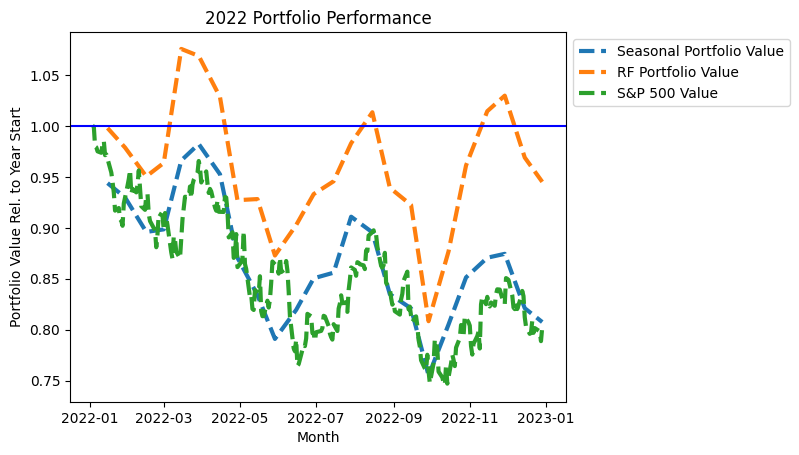

In [158]:
# Calculate strategy returns
long_2022_per_window_ret = long_2022.groupby(
    'trade window')['actual_return'].mean()
np.product(long_2022_per_window_ret + 1)  # 2.7% cumulative return for seasonal trade, no slippage
long_2022_ml_per_window_ret = long_2022[rf_trade_2022 == 1].groupby(
    'trade window')['actual_return'].mean()
np.product(long_2022_ml_per_window_ret + 1)  # 20.1% cumulative return for random forest, no slippage

# Plot portfolio performance, but assume a 1% penalty in all stock trades
# due to trade frictions
long_2022_graph = long_2022.groupby(
    'trade window')['actual_return'].mean().reset_index()
l22 = long_2022_graph.merge(long_2022[rf_trade_2022 == 1].groupby(
    'trade window')['actual_return'].mean().rename('actual_return_ml').reset_index(),
                     on='trade window',how='left')

l22['return_value'] = 0.99 + l22['actual_return']
l22['cum_value'] = l22['return_value'].cumprod()
l22['return_value_ml'] = np.where(np.isnan(l22['actual_return_ml']), 1,
                                  0.99 + l22['actual_return_ml'])
l22['cum_value_ml'] = l22['return_value_ml'].cumprod()

spx_2022_start_price = spx.loc['2022-01-03']['Adj Close']
spx_2022 = spx.loc['2022-01-03':'2022-12-30']
fig, ax = plt.subplots()
l22['date']= pd.to_datetime(l22['trade window'])
date_lag = timedelta(days=14) # offset the X axis by 2 weeks 

ax.plot(l22['date']+date_lag, l22['cum_value'],
            label='Seasonal Portfolio Value', linewidth=3.0, linestyle='dashed')
ax.plot(l22['date']+date_lag, l22['cum_value_ml'],
             label='RF Portfolio Value', linewidth=3.0, linestyle='dashed')
ax.plot(spx_2022.index, spx_2022['Adj Close']/spx_2022_start_price,
             label='S&P 500 Value', linewidth=3.0, linestyle='dashed')
ax.axhline(y=1, color='blue')

plt.title("2022 Portfolio Performance")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel("Portfolio Value Rel. to Year Start")
plt.xlabel('Month')
plt.show()

## Discussion

While the cumulative  returns for the seasonal strategy and random forest strategy in 2022 are quite good for a bearish year, at 2.7% and 20.1%, respectively, versus a 20% loss in the S&P500, these values are calculated assuming the absence of trade frictions. Incorporating trade frictions of 1% of the stock's value causes the seasonal strategy to yield a return very similar to just holding the S&P500. However, the distribution of random forest returns when first averaged by trading window (instead of a simple average across all trades) is such that the random forest has a cumulative loss of 5.5% for 2022, quite a bit better than for the other two strategies.

Now repeat for 2023:

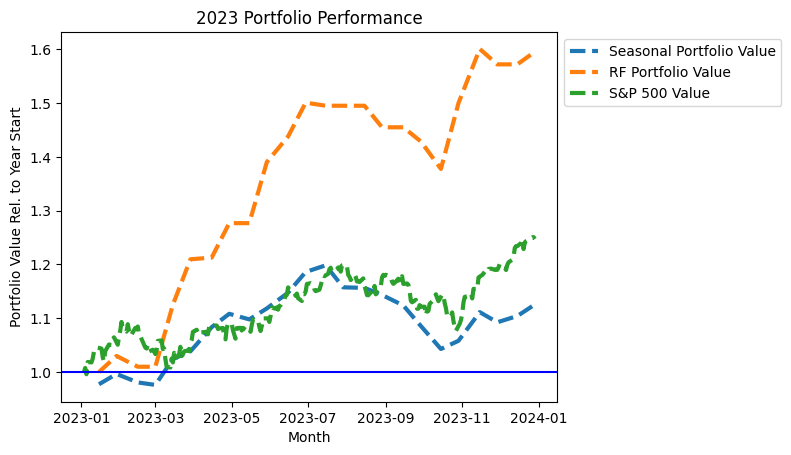

In [170]:
# Now for 2023:
long_2023_per_window_ret = long_2023.groupby(
    'trade window')['actual_return'].mean().values
np.product(long_2023_per_window_ret + 1) # 42.7% cum return for seasonal
long_2023_ml_per_window_ret = long_2023[rf_trade_2023 == 1].groupby(
    'trade window')['actual_return'].mean().values
np.product(long_2023_ml_per_window_ret + 1)  # 88.1% cum return for random forest

# Plot portfolio performance with 1% penalty in all stock trades
long_2023_graph = long_2023.groupby(
    'trade window')['actual_return'].mean().reset_index()
l23 = long_2023_graph.merge(long_2023[rf_trade_2023 == 1].groupby(
    'trade window')['actual_return'].mean().rename('actual_return_ml').reset_index(),
                     on='trade window',how='left')

l23['return_value'] = 0.99 + l23['actual_return']
l23['cum_value'] = l23['return_value'].cumprod()
l23['return_value_ml'] = np.where(np.isnan(l23['actual_return_ml']), 1,
                                  0.99 + l23['actual_return_ml'])
l23['cum_value_ml'] = l23['return_value_ml'].cumprod()

spx_2023_start_price = spx.loc['2023-01-03']['Adj Close']
spx_2023 = spx.loc['2023-01-03':'2023-12-30']
fig, ax = plt.subplots()
l23['date']= pd.to_datetime(l23['trade window'])
date_lag = timedelta(days=14) # offset the X axis by 2 weeks 

ax.plot(l23['date']+date_lag, l23['cum_value'],
            label='Seasonal Portfolio Value', linewidth=3.0, linestyle='dashed')
ax.plot(l23['date']+date_lag, l23['cum_value_ml'],
             label='RF Portfolio Value', linewidth=3.0, linestyle='dashed')
ax.plot(spx_2023.index, spx_2023['Adj Close']/spx_2023_start_price,
             label='S&P 500 Value', linewidth=3.0, linestyle='dashed')
ax.axhline(y=1, color='blue')

plt.title("2023 Portfolio Performance")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel("Portfolio Value Rel. to Year Start")
plt.xlabel('Month')
plt.show()

## Discussion

As before, taking the simple returns of the seasonal and random forest strategies would yield very large returns of 42.7% and 88.1% for 2023, respectively, compared to 24.7% for the S&P500. Incorporating a 1% friction accordingly reduces the seasonal strategy by around 30% to 12.5% for the year; this reduction is a lot smaller for the random forest strategy, which only traded at least one stock on 17 out of 24 trading windows, for an annual return of 59.5%. In this case, the presence of trade frictions makes it so that taking fewer, higher-return trades will yield greater profits than taking more, lower-return trades.

Overall, these two examples highlight the importance of accounting for trading frictions: they negatively impact the returns of the simple seasonal strategy such that while it outperformed the S&P500 in 2022/2023, frictions made it perform comparably or even worse than a simple index strategy.

In [201]:
# Get max drawdown as function of array of returns (in order)
# A fun leetcode problem...

def max_drawdown(arr):
    drawdown = 0
    max_drawdown = 0
    for i in range(len(arr)):
        if np.isnan(arr[i]):
            continue
        if arr[i] > 0:
            drawdown = 0
        else:
            drawdown += arr[i]
            if drawdown < max_drawdown:
                max_drawdown = drawdown
    return max_drawdown

# Sample SP500 semi-monthly (using trade windows, backfilled as necessary)
spx_bfill = spx.reindex(all_dates, method='bfill')

spx_bfill_vals_2022 = spx_bfill.loc[np.sort(long_2022['trade window'].unique())]
spx_bfill_rets_2022 = np.log(spx_bfill_vals_2022['Adj Close'] / spx_bfill_vals_2022['Adj Close'].shift(1))
spx_bfill_vals_2023 = spx_bfill.loc[np.sort(long_2023['trade window'].unique())]
spx_bfill_rets_2023 = np.log(spx_bfill_vals_2023['Adj Close'] / spx_bfill_vals_2023['Adj Close'].shift(1))

# Lastly, as a point of reference, the largest drawdowns for each strategy/year are given below
print('Largest drawdown in 2022 for seasonal: %5.3f' % -max_drawdown(l22['actual_return']-.01))
print('Largest drawdown in 2022 for RF: %5.3f' % -max_drawdown(l22['actual_return_ml']-.01))
print('Largest drawdown in 2022 for S&P 500: %5.3f' % -max_drawdown(spx_bfill_rets_2022))
print('Largest drawdown in 2023 for seasonal: %5.3f' % -max_drawdown(l23['actual_return']-.01))
print('Largest drawdown in 2023 for RF: %5.3f' % -max_drawdown(l23['actual_return_ml']-.01))
print('Largest drawdown in 2023 for S&P 500: %5.3f' % -max_drawdown(spx_bfill_rets_2023))


Largest drawdown in 2022 for seasonal: 0.210
Largest drawdown in 2022 for RF: 0.215
Largest drawdown in 2022 for S&P 500: 0.156
Largest drawdown in 2023 for seasonal: 0.137
Largest drawdown in 2023 for RF: 0.084
Largest drawdown in 2023 for S&P 500: 0.064


In [200]:
l23['actual_return_ml']-.01

0          NaN
1     0.029736
2    -0.019417
3          NaN
4     0.114263
5     0.075077
6     0.002561
7     0.052873
8          NaN
9     0.088865
10    0.034402
11    0.043643
12   -0.003812
13         NaN
14         NaN
15   -0.026813
16         NaN
17   -0.018152
18   -0.035695
19    0.088763
20    0.067258
21   -0.017943
22         NaN
23    0.014881
Name: actual_return_ml, dtype: float64